#   Differential Gene Expression Analysis

![](./images/Module2/DE_pipeline.jpg)

The next step in the pathway analysis workflow is differential expression (DE)  analysis. 
Differential expression (DE) analysis is a fundamental method in genomics and bioinformatics that aims to identify genes or genomic elements exhibiting significant changes in expression levels between different experimental conditions. This analytical approach is crucial for understanding how gene expression patterns vary in response to different biological contexts, such as comparing healthy and diseased tissues or assessing the impact of various experimental treatments. Typically applied to read count matrices or expression data obtained through technologies like RNA sequencing, the process includes data preprocessing, statistical analysis, multiple testing correction to control false discovery rates, and visualization techniques such as MA plots or volcano plots. 
This learning submodule demonstrates a computational workflow for the detection of DE genes from RNA-Seq data.

## Learning Objectives:
1. Assign samples into groups and set up design matrix.
2. Perform differential expression (DE) analysis using `limma`, `t-test`, `edgeR` and `DEseq` R packages.
3. Filter and export the results table.
4. Visualization of differential expression results.

In [1]:
#Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule2-1.html" width=100% height=250></iframe>')

## Loading the Dataset
In this section we will perform differential expression (DE) analysis to analyze the `GSE48350` dataset that we have used in the previous submodule.
Recall from the [**GEO Data processing** ](./Module01-GEO_Data_Processing.ipynb) section, `GSE48350` contains
sequenced data of Human Alzheimer's Disease using microarray sequencing technology collected from 4 brain regions.
To perform a Differential Expression (DE) analysis, we need to download the data previously saved in Google Cloud Bucket and then load it. We will utilize the same R commands as in the last submodule for downloading and loading the data

In [2]:
# Download the GSE48350.rds file to the "data" folder in current directory
system("gsutil cp gs://ccpa_bucket/GSE48350.rds ./data/")

In [3]:
# Loading data from the rds file and extracting the expression data, normalized expression data, and groups data
data <- readRDS("./data/GSE48350.rds")
expression_data <- data$expression_data
norm_expression_data <- data$norm_expression_data
samples <- data$samples
genes <- data$genes
head(norm_expression_data)

,GSM300173,GSM300177,GSM300181,GSM300186,GSM300189,GSM300192,GSM300196,GSM300204,GSM300208,GSM300214,⋯,GSM1176201,GSM1176202,GSM1176203,GSM1176204,GSM1176205,GSM1176206,GSM1176207,GSM1176208,GSM1176209,GSM1176210
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1007_s_at,0.6085351,0.8513945,1.1591995,2.0921063,1.2385797,0.8326798,0.8034588,0.6996407,1.3955209,1.1198790,⋯,1.1563261,1.6152382,1.1901788,1.4972300,0.6329609,1.4160284,1.2335104,1.2999401,0.8595833,1.2998189
1053_at,0.9081397,0.9336113,0.8563885,1.0015364,0.7332213,0.8570584,1.0210657,0.9641521,0.8585522,0.8584299,⋯,0.8848516,0.9385835,1.0359085,0.9225201,1.0405487,0.8187565,0.9541863,0.9855680,1.1704986,0.9924505
117_at,0.8674964,0.8385732,0.9956165,0.9797408,3.5688195,1.0145685,1.1729818,1.0208826,0.8163447,0.8572931,⋯,0.9469172,1.3414407,0.9509885,1.3277143,1.0712911,0.9801153,0.9847162,1.4585433,1.2102244,0.9023996
121_at,1.1053528,1.0432043,1.0137772,1.0931698,1.0356631,0.9435998,1.1165266,1.0960624,1.0099041,1.0553276,⋯,1.0055602,0.8999849,0.9461904,1.2250262,1.0535747,0.9321033,1.0115234,1.0048561,1.1175232,1.0730404
1255_g_at,1.2764652,0.8625501,1.0411838,1.0323309,0.8504494,1.3334491,1.1356378,1.0168769,0.9045680,0.8634836,⋯,1.3178803,0.8809971,0.9128050,1.0231747,1.0368457,0.9140167,1.0870208,0.9601511,3.4069852,1.0806457
1294_at,0.8337133,1.0081274,1.0330204,1.5409547,0.8751729,1.0063332,0.7226255,0.9519509,0.8132348,1.0214182,⋯,1.2466778,1.8324052,0.8732074,1.4028883,0.9107665,0.9586981,1.1221024,1.1861940,1.0770138,1.2797908


To perform differential expression analysis, samples need to be grouped based on different conditions. In this case, since we are using the `GSE48350` dataset, the samples should be divided into two groups: "disease" and "control". From the samples source name, patients diagnosed with Alzheimer’s Disease are annotated with ‘AD’.
Therefore, any samples that contain the string ‘AD’ are labeled by ‘d’ (condition/disease) and the remaining samples are assigned to ‘c’ (control/normal).
The code to group the samples is presented below:

In [4]:
# Select disease samples
disease_idx <- grep("AD", samples$source_name_ch1)
# Create a vector to store the label
groups <- rep("X", nrow(samples))
# Annotate disease samples as "d"
groups[disease_idx] <- "d"
# Control samples are labeled as "c"
groups[which(groups != "d")] <- "c"
groups <- factor(groups)

To see the number of *control* and *disease*, we can use the following command:

In [5]:
# show the number of control and disease in groups variable
table(groups)

groups
 c  d 
39 15 

Now we have all the data needed to perform DE analysis. We will use 4 different methods to perform differential expression analysis: `limma`, `t-tests`, `edgeR`, and `DESeq2`.

## DE Analysis Using limma.
By far, the most popular package for performing differential expression is `limma`. This package provides a flexible framework for the analysis of gene expression data, with a focus on detecting differentially expressed genes between two or more conditions.
It offers a variety of statistical methods and models to handle different experimental designs, including single and multiple groups, paired samples, and time-series data. It also includes various normalization and quality control procedures to preprocess raw data and improve the accuracy and reproducibility of downstream analysis.


Traditional approaches for analyzing gene expression data normally treat the variances of each gene as independent and estimate them based on the limited number of samples available. However, this can lead to inaccurate estimates due to the small sample size and high variability of gene expression data.
To address this problem, in `limma`, the empirical Bayesian (EB) statistical methods are used to improve the estimation of gene-specific variances and fold changes in the analysis of gene expression data.
These methods leverage information from other genes within the same dataset to enhance the accuracy of estimating gene-specific variances. This is achieved by initially estimating the overall distribution of variances across all genes and subsequently utilizing this distribution to estimate the variances for individual genes.
By doing so, it can improve the detection of differentially expressed genes, particularly for genes with low expression levels or small sample sizes. The EB methods also provide more stable estimates of variances across multiple experiments, making it easier to compare results across different datasets.

In [6]:
# Specify path to install site packages
.libPaths("/home/jupyter/.R/library")

In [7]:
suppressMessages({
    if (!require("BiocManager", quietly = TRUE)) {
        suppressWarnings(install.packages("BiocManager"))
    }
    suppressWarnings(BiocManager::install("limma", update = T))
    
})

suppressPackageStartupMessages({
    library("limma")
})

To perform the `limma` analysis, we will utilize the `runLimma` function provided below. This function requires a normalized expression matrix, a design matrix, and a contrast matrix as inputs to execute the `limma` test using the `lmFit` and `eBayes` functions. Subsequently, the `topTable` function from the limma package will be employed to generate a table of the top-ranked genes based on the fitted model. By default, `topTable` organizes genes from the smallest to the largest adjusted p-value, including associated gene information, log-FC, average log-CPM, moderated t-statistic, raw and adjusted p-values for each gene. The desired number of top genes to be displayed can be specified, where `number=Inf` includes all genes. Following the analysis, the `runLimma` function will return a dataframe containing the results of the analysis.

In [8]:
#' @description This function performs differential expression analysis using limma
#'
#' @param normExprs A matrix or data frame containing gene expression values. Rows represent genes, and columns represent samples.
#' @param design A matrix or data frame specifying the experimental design for the linear model. Each column corresponds to a different experimental factor or covariate.
#' @param contrast A matrix or data frame defining the contrasts of interest for the differential expression analysis. Each row represents a contrast.
#' @return A list containing a limma-fitted model and an analysis result dataframe.

# runLimma function for differential expression analysis using limma package
runLimma <- function(normExprs, design, contrast) {
    
    # Fit a linear model
    fit <- lmFit(object = normExprs, design = design) 
    # Specify contrasts for differential expression
    fit <- contrasts.fit(fit = fit, contrasts = contrast) 
    # Empirical Bayes moderation of standard errors
    fit <- eBayes(fit)
    
    # Extract results and additional information
    DERes <- topTable(fit, coef = 1, number = nrow(normExprs), confint=TRUE)
    
    DERes$PROBEID <- rownames(DERes)
    DERes$p.value <- DERes$P.Value
    DERes$statistic <- DERes$t
    DERes$avgExpr <- DERes$AveExpr
    DERes$pFDR <- DERes$adj.P.Val
    
    # Return a dataframe containing limma results
    limma_res = DERes[, c("PROBEID", "p.value", "pFDR", "statistic", "logFC", "avgExpr")]
   
}

To use the `runLimma` function, we need to set up the design and contrast matrices. We can achieve this by separating our dataset's samples into the groups of interest. We will use the `model.matrix` function from `limma` package for this purpose. This function generates a design matrix with 0s and 1s, where each row corresponds to a sample, and each column represents a sample group. If there's a 1 in a cell, it indicates that the sample belongs to that specific group.

In [9]:
# groups <- factor(groups$groups)
# Create design matrix with no intercept
design <- model.matrix(object = ~0 + groups)
colnames(design) <- levels(groups)
head(design)

,c,d
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0


To create the contrast matrix, we need to specify the comparison we're interested in. In this analysis, with two groups, we only have one contrast of interest. Multiple contrasts can be defined in the `makeContrasts` function.
To use the `makeContrasts` function, we need to pass the following arguments:

- `contrasts`: A character string specifying contrasts.
- `levels`: A character vector or factor giving the names of the parameters of which contrasts are desired, or a design matrix or other object with the parameter names as column names.

The `makeContrasts` function returns a matrix with columns corresponding to contrasts.


In [10]:
# Set up contrasts of interest and recalculate model coefficients
cts <- paste("c", "d", sep = "-")
cont.matrix <- makeContrasts(contrasts = cts, levels = design)
cont.matrix

,c-d
c,1
d,-1


Now we can use the `runLimma` function to perform limma DE analysis.

In [11]:
# Run limma analysis using runLimma function
limma_results <- runLimma(normExprs = norm_expression_data, design = design, contrast = cont.matrix)
# Print some top genes of limma result
head(limma_results[order(limma_results$pFDR), ])


,PROBEID,p.value,pFDR,statistic,logFC,avgExpr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
222178_s_at,222178_s_at,4.019112e-55,2.197450e-50,-73.01106,-0.4473780,0.3653633
224687_at,224687_at,5.489424e-46,1.500671e-41,-48.92036,-4.1431631,2.2572347
207488_at,207488_at,4.735684e-41,8.630785e-37,-39.29933,-0.4017530,0.6243144
239226_at,239226_at,7.626558e-34,1.042455e-29,28.36499,0.4483302,1.3245501
234109_x_at,234109_x_at,2.635337e-33,2.881741e-29,-27.67010,-0.2289726,0.7508256
212833_at,212833_at,2.914912e-30,2.656213e-26,-24.01172,-2.5976592,1.7308944


### Visualization of Limma Results.

The visualization of differential expression (DE) results is pivotal for unraveling complex patterns within genomic data. As the outcomes of DE analysis often encompass numerous genes exhibiting diverse expression changes, employing effective visualization methods becomes essential to distill this information into interpretable and insightful representations. These visualizations not only assist in pinpointing significant gene expression differences but also contribute to uncovering broader trends and relationships. In this instruction, we will explore two specific visualization tools: the MA plot and the volcano plot. The MA plot provides a detailed view of individual gene expression changes, while the volcano plot serves as a comprehensive overview, highlighting genes with significant differential expression in a visually intuitive manner. Together, these visualizations could enhance our understanding of the genomic landscape affected by experimental factors

#### MA plot
To visually summarize results for all genes from the DE analysis methods, we can use MA plots, which displays the difference between the average expression level (x-axis) against the log2 fold-change (y-axis), with the differentially expressed genes highlighted. 
In a usual MA plot, most points gather around a line showing zero change. If any points move up or down, it means there's a problem in the data that needs to be corrected. 
To create an MA plot, we will use the `ggplot2` package and the `plotMA` function below.

In [12]:
# Install and import the ggplot2 package
suppressWarnings({
    suppressMessages({
        install.packages("ggplot2")
        library(ggplot2)
    })
})

In [13]:
#' @description This function visualizes differential expression results with an MA plot
#'
#' @param DEResult Dataframe containing differential expression results, typically generated by a DE analysis function.
#' @param pThreshold Threshold for statistical significance of p-values (default: 0.05).
#' @param useFDR Logical indicating whether to use adjusted p-values (False Discovery Rate - FDR) for significance (default: TRUE).
#' @param logFCThreshold Threshold for absolute log-fold change to consider genes as differentially expressed (default: 1).
#' @param labels Vector of gene labels for highlighting specific genes (default: NULL).
#' @param fitMethod Method for fitting the smooth curve in the MA plot ("loess" or "lowess", default: "loess").
#' @return A plot visualizing the differential expression results with an MA plot.

plotMA <- function(DEResult, pThreshold = 0.05, useFDR = TRUE, logFCThreshold = 1, labels = NULL, fitMethod = "loess") {
   
    plotDat <- data.frame(
        x = DEResult$avgExpr,
        y = DEResult$logFC,
        isSig = (
            if (useFDR) {
                DEResult$pFDR < pThreshold
            } else {
                DEResult$p.value < pThreshold
            }
        )
    )

    plotDat$color <- factor(plotDat$isSig * (abs(plotDat$y) > logFCThreshold) * sign(plotDat$y), levels = c(1, -1, 0))

    if (!is.null(labels)) {
        plotDat$label <- labels[DEResult$PROBEID]
    }

    pl <- ggplot(plotDat, aes(x = .data$x, y = .data$y, color = .data$color)) +
        geom_point() +
        theme_bw() +
        theme_minimal() +
        theme(
            axis.line.x = element_blank(),
            axis.line.y = element_blank(),
        ) +
        scale_color_manual(
            values = c(
                "1" = "#B80F0A",
                "-1" = "#004F98",
                "0" = "darkgray"
            ),
            labels = c(
                "1" = paste0("Upregulated (", sum(plotDat$color == 1, na.rm = TRUE), ")"),
                "-1" = paste0("Downregulated (", sum(plotDat$color == -1, na.rm = TRUE), ")"),
                "0" = paste0("Not significant (", sum(plotDat$color == 0, na.rm = TRUE), ")")
            ),
            guide = guide_legend(override.aes = list(size = 3), title = "Significance")
        ) +
        theme(
            legend.position = "bottom"
        ) +
        labs(
            x = "Average expression",
            y = "Log2 fold change"
        ) +
        geom_hline(yintercept = -logFCThreshold, linetype = "dashed") +
        geom_hline(yintercept = logFCThreshold, linetype = "dashed")

    if (!is.null(labels)) {
        labelDat <- filter(plotDat, !is.na(.data$label))

        pl <- pl + geom_label_repel(
            labelDat,
            mapping = aes(x = .data$x, y = .data$y, label = .data$label),
            size = 3,
            segment.size = 0.75,
            segment.color = "#888888",
            color = "black",
            box.padding = 1,
            force = 3,
            point.size = NA
        )
    }

    if (!is.null(fitMethod)) {
        pl <- pl + geom_smooth(
            method = fitMethod,
            se = FALSE,
            color = "#228b22"
        ) +
            geom_hline(yintercept = 0, color = "#888888")
    }

    pl

}

To create an MA plot for the limma analysis result, we will use the `plotMA` function as follows: 

`geom_smooth()` using formula = 'y ~ x'


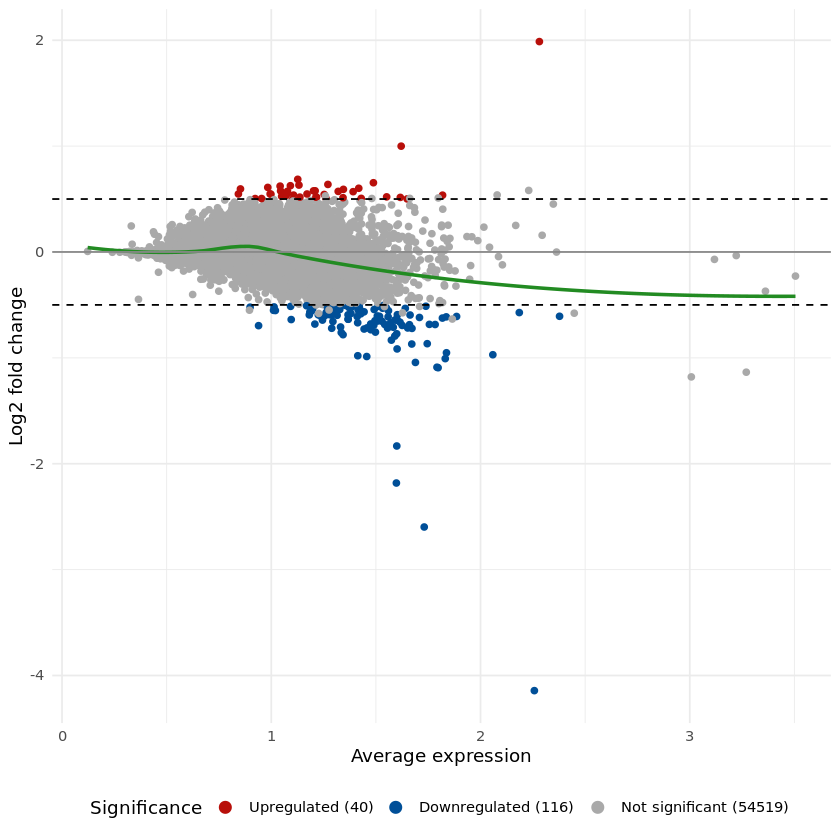

In [14]:
# Create a MA plot for limma results
plotMA(DEResult = limma_results, pThreshold = 0.05, useFDR = FALSE, logFCThreshold = 0.5, labels = NULL, fitMethod = "loess")

We construct the MA plot by the significance defined using a p-value cutoff that is set at 5% by default. For the comparison between expression levels in *“disease”* (d) and *“control”* (c), 116 genes are found to be down-regulated and 40 genes are up-regulated. 

In [15]:
# Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule2-2.html" width=100% height=250></iframe>')

### Volcano plot
The volcano plot is a special type of scatterplot that is commonly used for visualizing the results of DE analyses. In a volcano plot, the *x* axis shows the *log-fold* change and the *y* axis is some measure of statistical significance, which in this case is the log-odds, or “B” statistic. A characteristic “volcano” shape should be seen. To create a volcano plot, we can use the function `plotVolcanoDE` bellow.

In [16]:
#' @description This function generates a volcano plot based on DE analysis results 
#'
#' @param DEResult Dataframe containing differential expression results, typically generated by a DE analysis function.
#' @param pThreshold Threshold for statistical significance of p-values (default: 0.05).
#' @param useFDR Logical indicating whether to use adjusted p-values (False Discovery Rate - FDR) for significance (default: TRUE).
#' @param logFCThreshold Threshold for absolute log-fold change to consider genes as differentially expressed (default: 1).
#' @return A filtered dataframe containing significant differential expression results.
#' @examples
#' filtered_result <- filter_differential_expression(de_result, pThreshold = 0.05, useFDR = TRUE, logFCThreshold = 0.5)

plotVolcanoDE <- function(DEResult, pThreshold = 0.05, useFDR = TRUE, logFCThreshold = 1) {


    if (!"logFC" %in% colnames(DEResult)) {
        stop("The logFC column is not in the results data frame.")
    }

    if (useFDR && !("pFDR" %in% colnames(DEResult))) {
        stop("The pFDR column is not in the results data frame.")
    } else if (!("p.value" %in% colnames(DEResult))) {
        stop("The p.value column is not in the results data frame.")
    }

    pvalues <- if (useFDR) {
        DEResult$pFDR
    } else {
        DEResult$p.value
    }

    plotDat <- data.frame(
        x = DEResult$logFC,
        y = -log10(pvalues),
        color = ifelse(abs(DEResult$logFC) > logFCThreshold & pvalues < pThreshold,  DEResult$logFC, NA)
    )

    isNoSig <- FALSE
    if (sum(is.na(plotDat$color)) == nrow(plotDat)) {
        isNoSig <- TRUE
        plotDat$color <- "gray"
    }

    pl <- ggplot(plotDat, aes(x = .data$x, y = .data$y, color = .data$color)) +
        geom_point() +
        geom_hline(yintercept = -log10(pThreshold), linetype = "dashed", color = "black") +
        geom_vline(xintercept = -logFCThreshold, linetype = "dashed") +
        geom_vline(xintercept = logFCThreshold, linetype = "dashed") +
        labs(
            x = "log2 fold change",
            y = if (useFDR) {
                "-log10 pFDR"
            } else {
                "-log10 p-value"
            }
        ) +
        theme_bw() +
        theme(
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.line.x = element_line(color = "darkgray"),
            axis.line.y = element_line(color = "darkgray"),
            plot.title = element_text(hjust = 0.5),
            legend.position = "none"
        )


    if (!isNoSig) {
        pl <- pl + scale_color_gradient(low = "blue", high = "red", na.value = "gray")
    } else {
        pl <- pl + scale_color_manual(values = "gray")
    }

    pl

}

For the volcano plot of the limma analysis result, we will use the following code:

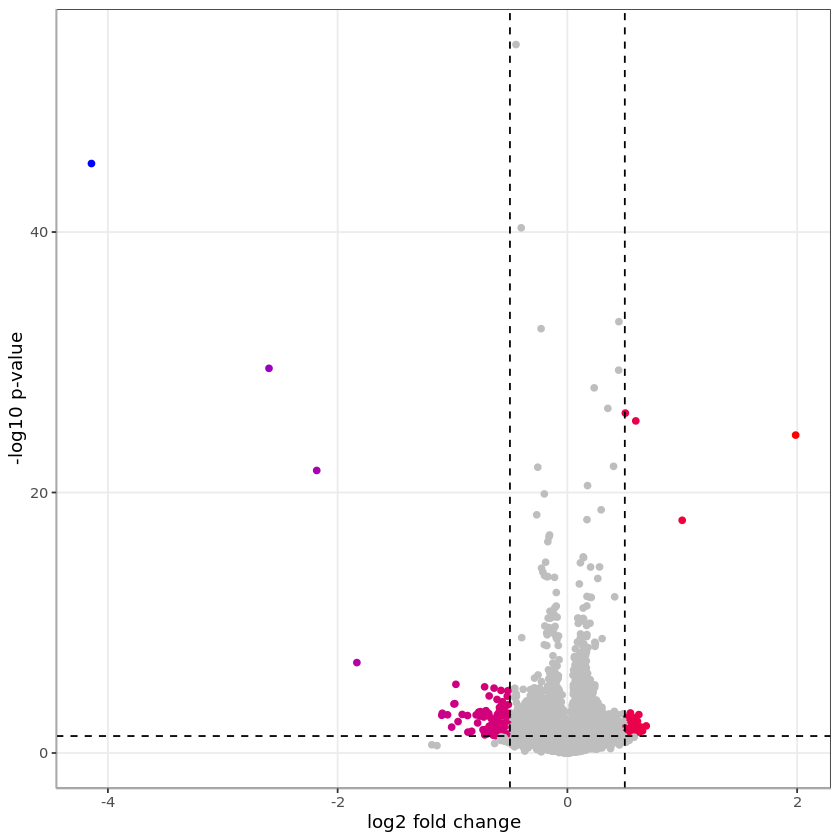

In [17]:
# Create a volcano plot for limma results
plotVolcanoDE(DEResult = limma_results, pThreshold = 0.05, useFDR = FALSE, logFCThreshold = 0.5)

Now, we can use the following commands to save the limma DE analysis result.

In [18]:
# Save the data to the local disk using either rds or csv format
# Add one column to store the probe IDs
saveRDS(limma_results, file = "./data/limma_results.rds")
write.csv(limma_results, file = "./data/limma_results.csv")

# Add the limma result to the data list to save them all together in an rds file, we will do the same to other methods
data$limma_results <- limma_results

In [19]:
# Save files in Google Cloud Bucket
# Replace the <BUCKET_NAME> with the name of your bucket that was previously made in submodule 1
# system("gsutil cp ./data/limma_results.rds gs://<BUCKET_NAME>", intern = TRUE)
system("gsutil cp ./data/limma_results.rds gs://ccpa_bucket", intern = TRUE)

character(0)

## DE Analysis Using t-test
In gene expression analysis, t-test serves as a widely used statistical method for detecting differentially expressed (DE) genes. The fundamental concept underlying a t-test is to assess the difference in means relative to the variability within each group. A more substantial difference in means, in comparison to the variability within each group, suggests a higher likelihood of the difference being statistically significant.

In the context of gene expression data, a t-test is typically applied to each gene separately. For each gene, the mean expression level in the treatment group is compared to the mean expression level in the control group. T-test produces a p-value that indicates the probability of observing the observed difference in means by chance.
In order to identify DE genes, a significance threshold (or "alpha value") is chosen. Any gene with a p-value below this threshold is considered to be differentially expressed. The threshold is typically set at 0.05, meaning that there is a 5% chance of falsely identifying a gene as DE. We can use `row_t_welch` available in the `matrixTests` package to perform t-test between the two groups for each gene. Below is the code to install the necessary packages:

In [20]:
suppressMessages({
    suppressWarnings(install.packages("matrixTests", quiet = T))
})

# Load matrixTests package
suppressPackageStartupMessages({library("matrixTests")})

To conduct t-Test differential expression (DE) analysis, we can utilize the `runtTest` function in the provided code. The required inputs include an expression matrix, group information, and the type of alternative hypothesis for the test. The function will yield a dataframe containing the statistical results of the analysis.

In [21]:
#' @description This function performs differential expression analysis using t-test 
#'
#' @param countMatrix A matrix of gene expression data where rows represent genes and columns represent samples.
#' @param groups A vector specifying the grouping of samples. Should have the same length as the number of columns in countMatrix.
#' @param alternative The type of alternative hypothesis for the t-test ("two.sided", "less", or "greater").
#' @return A dataframe containing the result of the analysis.

runtTest <- function(countMatrix, groups, alternative = "two.sided") {
    
    # Divide the countMatrix matrix into two separate matrices X and Y. X is the control group and Y is the disease group
    X <- countMatrix[, groups == "c"]
    Y <- countMatrix[, groups == "d"]

    # Perform Welch's t-test using row_t_welch function
    tTest_res <- row_t_welch(x = X, y = Y, alternative = alternative, conf.level = 0.95)
    
    # Extract results and additional information    
    tTest_res$PROBEID <- rownames(tTest_res)
    tTest_res$p.value <- tTest_res$pvalue
    tTest_res$statistic <- tTest_res$statistic
    tTest_res$logFC <- log2(tTest_res$mean.y) - log2(tTest_res$mean.x)
    tTest_res$avgExpr <- rowMeans(countMatrix)
    
    # Adjust p-values for multiple testing using the false discovery rate (FDR)
    tTest_res$pFDR <- p.adjust(tTest_res$p.value, method = "fdr")
    
    # Return the results with only important columns
    tTest_res[, c("PROBEID", "p.value", "pFDR", "statistic", "logFC", "avgExpr")]
}



In [22]:
tTest_results <- runtTest(countMatrix = expression_data, groups = groups)
head(tTest_results)

,PROBEID,p.value,pFDR,statistic,logFC,avgExpr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1007_s_at,1007_s_at,0.05184888,0.2811781,-2.0051460,0.35692227,1.2204089
1053_at,1053_at,0.14564537,0.4614891,1.4947021,-0.12273031,0.9619194
117_at,117_at,0.50803064,0.7891654,0.6672922,-0.20236516,1.3897122
121_at,121_at,0.36963840,0.6966764,0.9124083,-0.04509567,1.0859968
1255_g_at,1255_g_at,0.29460785,0.6356102,1.0725955,-0.54032854,2.0647498
1294_at,1294_at,0.17979165,0.5092793,-1.3836421,0.20714232,1.1524454


We can create an MA plot and a heatmap plot for the t-test result as we did for limma above.

`geom_smooth()` using formula = 'y ~ x'


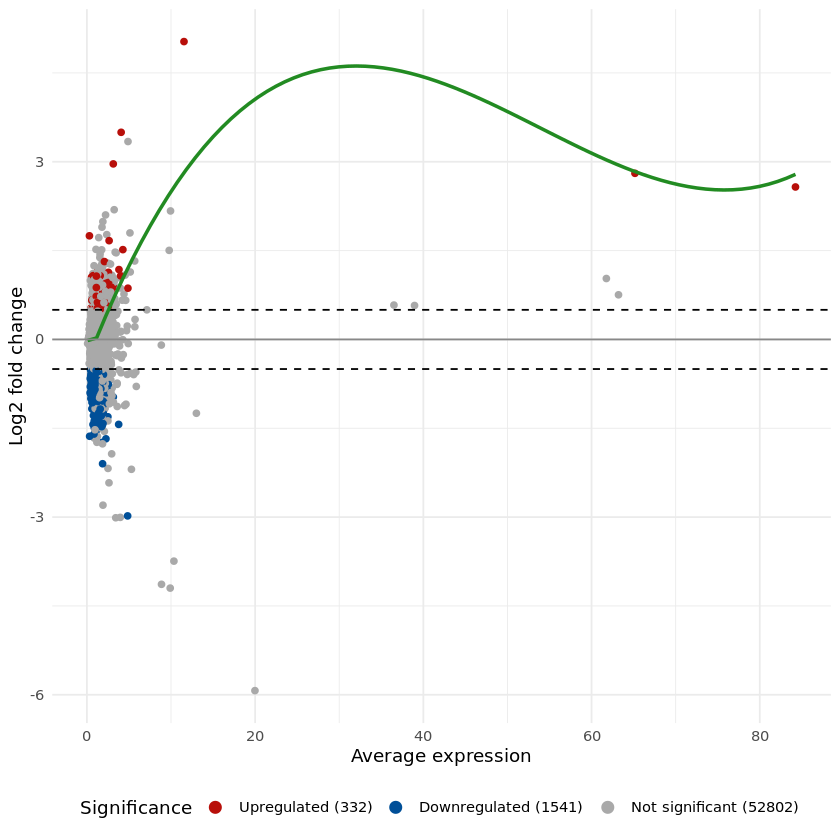

In [23]:
# Create a MA plot for t-Test results
plotMA(DEResult = tTest_results, pThreshold = 0.05, useFDR = FALSE, logFCThreshold = 0.5)

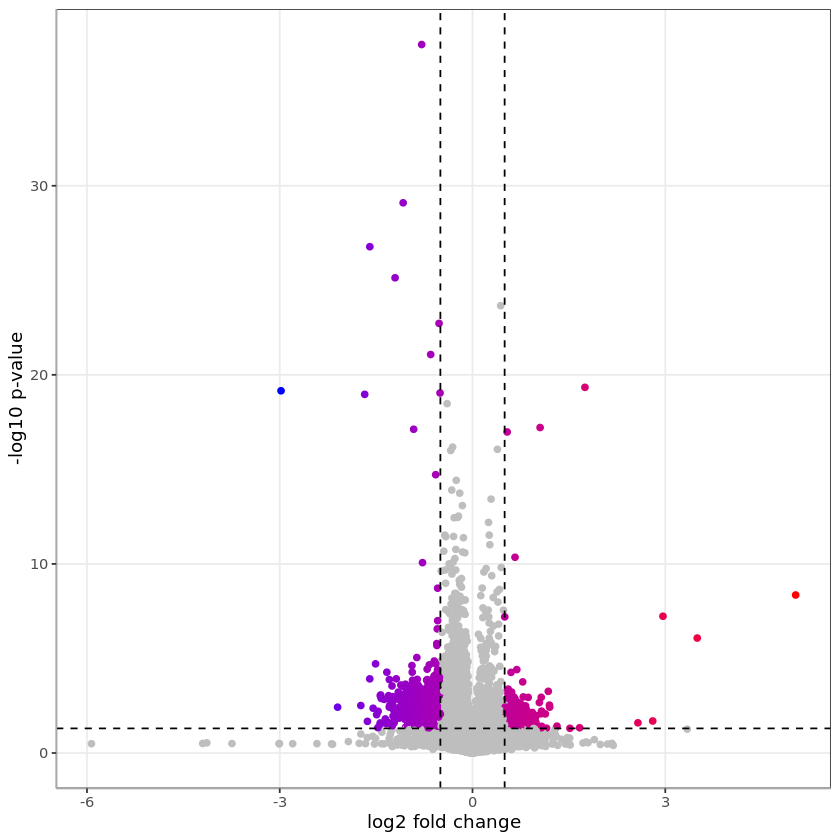

In [24]:
# Create a volcano plot for t-Test results
plotVolcanoDE(DEResult = tTest_results, pThreshold = 0.05, useFDR = FALSE, logFCThreshold = 0.5)

We can now save the data for the upcoming submodules using the commands below.

In [25]:
# Saving the result to local folder
write.csv(tTest_results, file = "./data/t-Test_Results.csv")
saveRDS(tTest_results, file = "./data/t-Test_Results.rds")

# Add the t-Test result to the data list to save them all together in a rds file
data$tTest_results <- tTest_results

In [26]:
# Saving the result to Google Cloud Bucket
# Replace <BUCKET_NAME> with name of your bucket that was perviously made in submodule 1
# system("gsutil cp ./data/t-Test_Results.csv gs://<BUCKET_NAME>", intern = TRUE)
system("gsutil cp ./data/t-Test_Results.csv gs://ccpa_bucket", intern = TRUE)

# system("gsutil cp ./data/t-Test_Results.rds gs://<BUCKET_NAME>", intern = TRUE)
system("gsutil cp ./data/t-Test_Results.rds gs://ccpa_bucket", intern = TRUE)

character(0)

character(0)

## DE Analysis Using edgeR

edgeR is a popular R package for differential expression (DE) analysis of RNA sequencing (RNA-seq) data. The package uses empirical Bayesian methods to account for biological variability and gene-specific sequencing depth, making it a robust and powerful tool for identifying DE genes.


The basic workflow for DE analysis using edgeR involves several steps:


1. Data pre-processing: Raw sequencing reads are first pre-processed to filter out low-quality reads and align them to a reference genome. This step typically includes quality control, read trimming and alignment.


2. Count matrix generation: A count matrix is generated by counting the number of reads that map to each gene in each sample. This matrix represents the raw gene expression data and is used as input for DE analysis.


3. Normalization: edgeR applies a normalization method called trimmed mean of M-values (TMM) to adjust for differences in sequencing depth between samples. This method calculates scaling factors for each sample based on the mean and variance of the log ratios of gene expression levels between pairs of samples.


4. Dispersion estimation: edgeR uses a negative binomial model to account for biological variability in gene expression data. This model estimates the dispersion of counts within and between samples, which reflects the amount of biological variability in gene expression data.


5. Differential expression analysis: edgeR uses a statistical framework called generalized linear models (GLMs) to test for differential expression between two or more groups. This method models the relationship between gene expression and experimental factors (e.g., treatment, time, condition) to identify genes that are significantly differentially expressed.


6. Multiple testing correction: To control for the high false positive rate associated with testing many genes simultaneously, edgeR applies a multiple testing correction method called the false discovery rate (FDR). This method adjusts p-values to control the expected proportion of false positives among all significant tests.


Overall, edgeR is a powerful and widely used tool for DE analysis of RNA-seq data, offering a flexible framework for the detection of DE genes that accounts for biological variability and gene-specific sequencing depth. It also provides several visualization tools to help users explore and interpret the results.

In [27]:
# Install edgeR package from Bioconductor
suppressMessages({ 
    if (!require("BiocManager", quietly = TRUE)) {
        install.packages("BiocManager")
    }
    suppressWarnings(BiocManager::install("edgeR"))
})
# Load edgeR package
suppressPackageStartupMessages({library("edgeR")})


To conduct differential expression (DE) analysis using the edgeR method, we can use the `runEdgeR` function. Similar to `runtTest`, `runEdgeR` function requires an expression matrix (countMatrix) and a groups factor (groups) and it will return a dataframe with essential statistical results for the edgeR DE analysis.

In [28]:
#' @description This function performs differential expression analysis using EdgeR 
#'
#' @param countMatrix A matrix of gene expression data where rows represent genes and columns represent samples.
#' @param groups A vector specifying the grouping of samples. Should have the same length as the number of columns in countMatrix.
#' @return A dataframe containing the result of the analysis.

runEdgeR <- function(countMatrix, groups) {
    
    # Creates a DGEList object from a table of counts (rows=features, columns=samples), 
    # group indicator for each column, library size (optional) and a table of feature annotation (optional).
    dge <- DGEList(counts = countMatrix, group = factor(groups))
    
    # Calculating the normalization factor
    dge <- calcNormFactors(object = dge)
    
    # Estimate dispersion
    dge <- estimateDisp(y = dge)
    
    # Perform exact test
    et <- exactTest(object = dge)
    
    # Getting top DE genes
    top_degs <- topTags(object = et, n = "Inf")  
    
    # Extract results and additional information
    top_degs$table$PROBEID <- rownames(top_degs$table)
    top_degs$table$p.value <- top_degs$table$PValue
    top_degs$table$pFDR <- top_degs$table$FDR
    top_degs$table$statistic <- top_degs$table$logFC
    top_degs$table$avgExpr <- top_degs$table$logCPM
    
    # Return the results with only important columns
    top_degs$table[, c("PROBEID", "p.value", "pFDR", "statistic", "logFC", "avgExpr")]
}

Using the `runEdgeR` function, we can now conduct the `edgeR` DE analysis with the provided code.

In [29]:
# Run the analysis using the runEdgeR function
edgeR_results <- runEdgeR(countMatrix = expression_data, groups = groups)
head(edgeR_results)

Using classic mode.



,PROBEID,p.value,pFDR,statistic,logFC,avgExpr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
224687_at,224687_at,4.463490e-158,2.440413e-153,4.904976,4.904976,8.019088
212833_at,212833_at,1.652705e-51,4.518082e-47,3.363579,3.363579,6.860991
1558620_at,1558620_at,2.269510e-37,4.136182e-33,2.841310,2.841310,6.619830
211318_s_at,211318_s_at,6.724743e-22,9.191883e-18,-2.788104,-2.788104,7.033454
206552_s_at,206552_s_at,1.493408e-15,1.633042e-11,3.236385,3.236385,7.042412
1553191_at,1553191_at,1.489697e-06,1.357487e-02,1.158600,1.158600,6.798425


We will also visualize the DE result of edgeR with an MA plot and a heatmap.

`geom_smooth()` using formula = 'y ~ x'


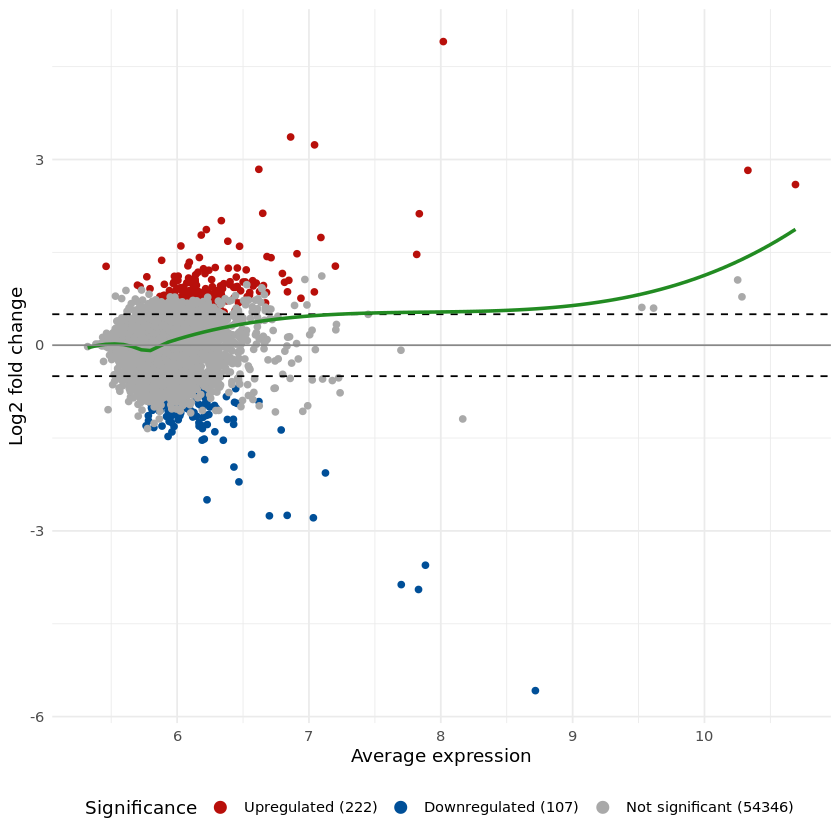

In [30]:
# Create a MA plot for edgeR results
plotMA(DEResult = edgeR_results, pThreshold = 0.05, useFDR = FALSE, logFCThreshold = 0.5)

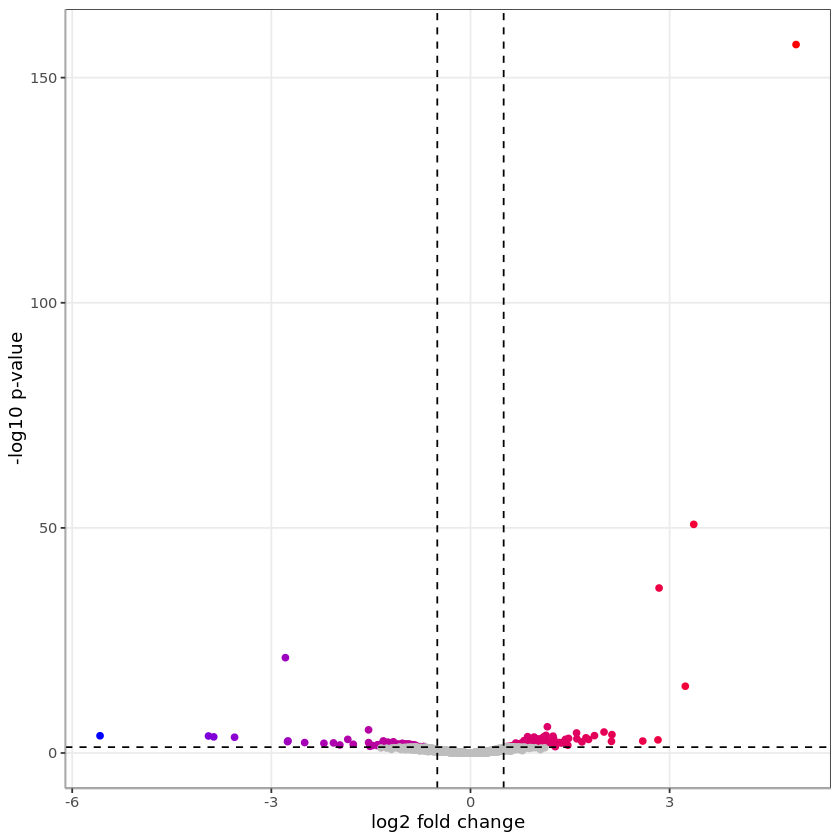

In [31]:
# Create a volcano plot for edgeR results
plotVolcanoDE(DEResult = edgeR_results, pThreshold = 0.05, useFDR = FALSE, logFCThreshold = 0.5)

In [32]:
# Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule2-3.html" width=100% height=250></iframe>')

Now, we can save the edgeR DE analysis result to use in the later submodules. 

In [33]:
# Saving the result to local folder
write.csv(edgeR_results, file = "./data/edgeR_Results.csv")
saveRDS(edgeR_results, file = "./data/edgeR_Results.rds")

# Add the edgeR result to the data list to save them all together in a rds file
data$edgeR_results <- edgeR_results

In [34]:
# Saving the result to Google Cloud Bucket
# Replace <BUCKET_NAME> with the name of your bucket that was previously made in submodule 1
# system("gsutil cp ./data/edgeR_Results.csv gs://<BUCKET_NAME>", intern = TRUE)
system("gsutil cp ./data/edgeR_Results.csv gs://ccpa_bucket", intern = TRUE)

# system("gsutil cp ./data/edgeR_Results.rds gs://<BUCKET_NAME>", intern = TRUE)
system("gsutil cp ./data/edgeR_Results.rds gs://ccpa_bucket", intern = TRUE)

character(0)

character(0)

## DE Analysis Using DESeq2
DESeq2 is a popular R package for differential expression (DE) analysis of RNA sequencing (RNA-seq) data. The package uses a negative binomial distribution to model the gene expression counts and applies shrinkage estimation to improve the accuracy of differential expression analysis.


The basic workflow for DE analysis using DESeq2 involves several steps:


1. Data pre-processing: Raw sequencing reads are first pre-processed to filter out low-quality reads and align them to a reference genome. This step typically includes quality control, read trimming, and alignment.


2. Count matrix generation: A count matrix is generated by counting the number of reads that map to each gene in each sample. This matrix represents the raw gene expression data and is used as input for DE analysis.


3. Normalization: DESeq2 applies a normalization method called size factors to adjust for differences in sequencing depth between samples. This method calculates scaling factors for each sample based on the total number of reads in each sample.


4. Dispersion estimation: DESeq2 estimates the dispersion of counts within and between samples using a negative binomial distribution. This model accounts for biological variability in gene expression data and can handle low counts and overdispersion.


5. Differential expression analysis: DESeq2 uses a statistical framework called the Wald test to test for differential expression between two or more groups. This method models the relationship between gene expression and experimental factors (e.g., treatment, time, condition) to identify genes that are significantly differentially expressed.


6. Multiple testing correction: To control for the high false positive rate associated with testing many genes simultaneously, DESeq2 applies a multiple testing correction method called the Benjamini-Hochberg (BH) procedure. This method adjusts p-values to control the expected proportion of false positives among all significant tests.


DESeq2 also includes several visualization tools, such as principal component analysis (PCA) and heatmaps, to help users explore and interpret the results.


Overall, DESeq2 is a powerful and widely used tool for DE analysis of RNA-seq data, offering a flexible framework for the detection of DE genes that accounts for biological variability and gene-specific sequencing depth. It is particularly useful for analyzing low-count genes and handling complex experimental designs.

In [35]:
# Installing and loading the library
suppressMessages({ 
    if (!require("BiocManager", quietly = TRUE)) {
        install.packages("BiocManager")
    }
    suppressWarnings(BiocManager::install("DESeq2", update = F))
    
})
suppressPackageStartupMessages({library("DESeq2")})

In [36]:
#' @description This function performs differential expression analysis using DESeq2
#'
#' @param countMatrix A matrix of gene expression data where rows represent genes and columns represent samples.
#' @param groups A vector specifying the grouping of samples. It should have the same length as the number of columns in countMatrix.
#' @return A dataframe containing the result of the analysis.

runDESeq2 <- function(countMatrix, groups) {
    
    # Constructing a group table that contains information about group members for all patients.
    coldata <- data.frame(
        sample = colnames(countMatrix),
        condition = as.factor(groups),
        row.names = "sample" 
    )
    
    # Suppressing messages to avoid printing DESeq2 messages
    suppressMessages({
        # Create a DESeqDataSet object
        dds <- DESeqDataSetFromMatrix(countData = round(countMatrix), colData = coldata,
                                      design = ~condition)
        # Relevel the 'condition' factor
        dds$condition <- relevel(x = dds$condition, ref = "c")
         # Filter out low-count rows
        dds <- dds[rowSums(counts(dds)) >= 10, ]
        # Run DESeq analysis
        dds <- DESeq(object = dds)
    })
    
    # Get names of results
    resultsNames(object = dds)
    
    # Get differential expression results
    res <- results(object = dds)
    
    # Order results by adjusted p-value
    res <- as.data.frame(res[order(res$padj), ])

    # Extract results and additional information
    res$PROBEID <- rownames(res)
    res$p.value <- res$pvalue
    res$statistic <- res$stat
    res$logFC <- res$log2FoldChange
    res$avgExpr <- log2(res$baseMean + 1)
    res$pFDR <- p.adjust(res$p.value, method = "fdr")
    
    # Return the results with only important columns
    res[, c("PROBEID", "p.value", "pFDR", "statistic", "logFC", "avgExpr")]
}


Now we can perform `DESeq2` analysis with the `runDESeq2` function. 

In [37]:
# Run the analysis using runDESeq2 function
DESeq2_results <- runDESeq2 (countMatrix = expression_data, groups = groups)
# Print out the first few rows of the result dataframe
head(DESeq2_results)

,PROBEID,p.value,pFDR,statistic,logFC,avgExpr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
224687_at,224687_at,2.267742e-82,1.154122e-77,19.225425,5.089289,3.654306
212833_at,212833_at,1.542557e-33,3.925268e-29,12.068860,3.430013,2.361315
1558620_at,1558620_at,7.093790e-25,1.203414e-20,10.299352,2.979229,2.057534
206552_s_at,206552_s_at,3.286586e-12,4.181606e-08,6.964891,3.353613,2.558323
211318_s_at,211318_s_at,1.662830e-11,1.692528e-07,-6.732927,-2.681179,2.569728
1553191_at,1553191_at,5.874238e-06,4.982627e-02,4.530866,1.176570,2.285702


Similar to previous methods, we will create an MA plot and a heatmap for DESeq2 result.

`geom_smooth()` using formula = 'y ~ x'


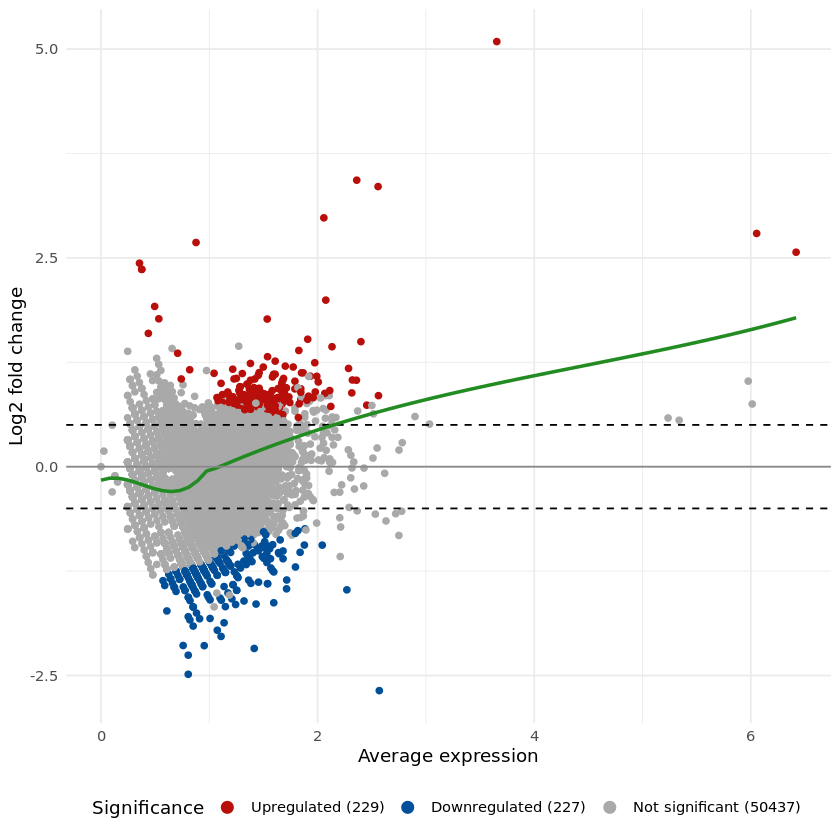

In [38]:
# Create a MA plot for DESeq2 results
plotMA(DEResult = DESeq2_results, pThreshold = 0.05, useFDR = FALSE, logFCThreshold = 0.5)

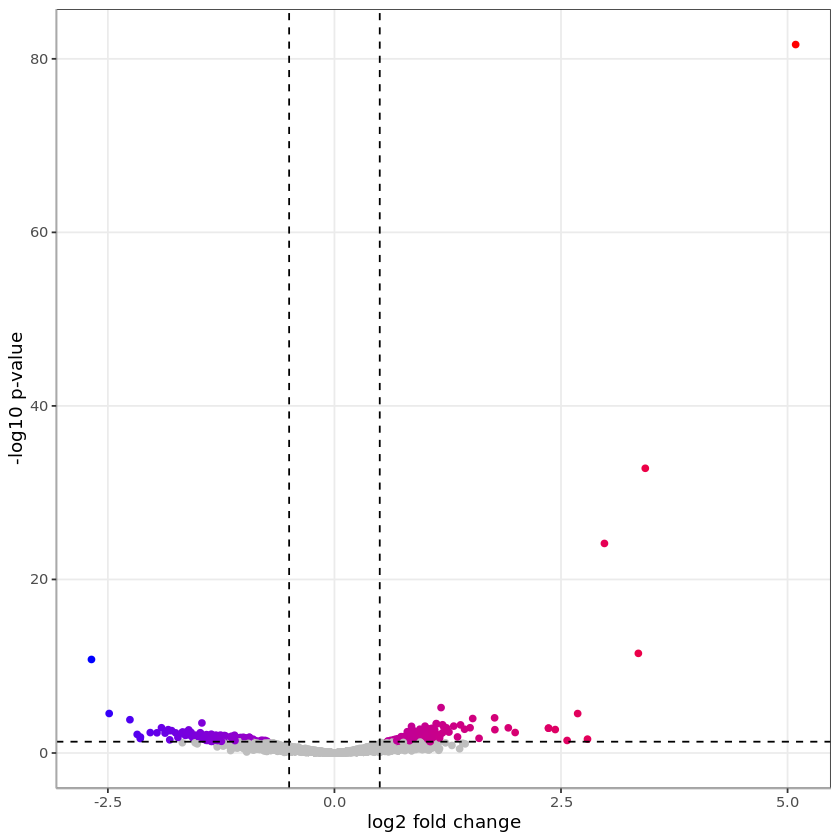

In [39]:
# Create a volcano plot for DESeq2 results
plotVolcanoDE(DEResult = DESeq2_results, pThreshold = 0.05, useFDR = FALSE, logFCThreshold = 0.5)

In [40]:
# Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule2-4.html" width=100% height=250></iframe>')

And we can save the DE analysis result to use in the later submodules.

In [41]:
# Saving the result to local storage
write.csv(DESeq2_results, file = "./data/DESeq2_Results.csv")
saveRDS(DESeq2_results, file = "./data/DESeq2_Results.rds")

# Add the DESeq2 result to the data list to save them all together in an rds file
data$DESeq2_results <- DESeq2_results

In [42]:
# Replace <BUCKET_NAME> with the name of your bucket that was previously made in submodule 1
# system("gsutil cp ./data/DESeq2_Results.csv gs://<BUCKET_NAME>", intern = TRUE)
system("gsutil cp ./data/DESeq2_Results.csv gs://ccpa_bucket", intern = TRUE)

# system("gsutil cp ./data/DESeq2_Results.rds gs://<BUCKET_NAME>", intern = TRUE)
system("gsutil cp ./data/DESeq2_Results.rds gs://ccpa_bucket", intern = TRUE)

character(0)

character(0)

After completing all the analysis methods, we can now save the results to a single RDS file for convenience in using them in submodules 4 and 5.

In [43]:
# Save all data to an rds file
saveRDS(data, file = "./data/GSE48350.rds")

In [44]:
# Save all data to Google Cloud Bucket
# Replace <BUCKET_NAME> with the name of your bucket that was previously made in submodule 1
# system("gsutil cp ./data/GSE48350.rds gs://<BUCKET_NAME>", intern = TRUE)
system("gsutil cp ./data/GSE48350.rds gs://ccpa_bucket", intern = TRUE)

character(0)

# Gene-level consensus analysis: Visualize analysis outcomes

To conduct a gene-level consensus analysis, we can visualize the relations between the results of different analysis methods. A Venn diagram, which uses overlapping circles or similar shapes to depict the logical relationships between two or multiple sets of items, can be utilized in this case. In addition, we can also use a heatmap to observe the differences between different DE analysis methods. We can create a Venn diagram or a Heatmap plot of differentially expressed (DE) genes among four different analysis methods using the following functions. 

In [45]:
# Install and import packages
suppressMessages({
    suppressWarnings(if (!require("ggvenn")) install.packages("ggvenn"))
    suppressWarnings(if (!require("ggnewscale")) install.packages("ggnewscale"))
    suppressWarnings(if (!require("tidyr")) install.packages("tidyr"))
                     
    suppressPackageStartupMessages({library(ggvenn)})
    suppressPackageStartupMessages({library(tidyr)})
    suppressPackageStartupMessages({library(ggnewscale)})
})

In [46]:
#' @ description This function generates a Venn diagram to visualize the overlap of differentially expressed genes or features
#'                 between multiple sets of results.
#'
#' @param aResults A list containing multiple sets of differential expression analysis results.
#'                 Each element in the list should be a data frame or a tibble with columns representing
#'                 differentially expressed genes or features and relevant statistics.
#' @param pThreshold The significance threshold for filtering differentially expressed genes (default: 0.05).
#' @param useFDR A logical value indicating whether to use normal p-value or FDR p-value to filter out the DE genes (default: TRUE).#' @param labels A named vector of labels for genes. Default is `NULL`.
#' @param stat The statistical metric to use for filtering genes (default: "logFC" for log-fold change).
#' @param statThreshold The threshold value for the chosen statistical metric to filter differentially expressed genes (default: 0).
#' @param topToList The number of top differentially expressed genes or features to include in the Venn diagram (default: 10).
#' @param resultType The type of result to consider (default: "gene"). Options include "gene" or "feature".
#'
#' @return A Venn diagram displaying the overlap of differentially expressed genes or features among the specified result sets.

plotVenn <- function(aResults, pThreshold = 0.05, useFDR = TRUE, stat = "logFC", statThreshold = 0) {
    if (length(aResults) < 2) {
        stop("The number of DE results must be at least 2.")
    }

    for (Res in aResults) {
        if (useFDR && !("pFDR" %in% colnames(Res))) {
            stop("The F DR adjusted p-value column is not in the results data frame.")
        } else {
            if (!("p.value" %in% colnames(Res))) {
                stop("The p.value column is not in the results data frame.")
            }
        }

        if (!stat %in% colnames(Res)) {
            stop("The statistic column is not in the results data frame.")
        }
    }

    plotDat <- lapply(aResults, function(Res) {
            filtered_df <- filter(data.frame(Res),
                abs(.data[[stat]]) > statThreshold & (
                    if (useFDR) {
                        .data$pFDR < pThreshold
                    } else {
                        .data$p.value < pThreshold
                    }
                )
            )
            filtered_df[["PROBEID"]]
    })
    
    if (is.null(names(plotDat))) {
        names(plotDat) <- paste0("Dataset ", seq_along(plotDat))
    }
    pR <- ggvenn::ggvenn(plotDat,
           fill_color = c(
               "#316b9d",
               # "#fce397",
               # "#99cc83",
               "#f77a65",
               "#a6a1d0",
               "#fea9c4",
               "#74e7bc",
               "#febb73",
               "#1db4db",
               "#ffc5a6",
               "#b6c9fa",
               "#ee5437"),
           stroke_size = 0.5,
           set_name_size = 4,
           fill_alpha = 0.75
    ) 
    
    xrange <- layer_scales(pR)$x$range$range
    yrange <- layer_scales(pR)$y$range$range


    pR <- pR + ggplot2::theme(plot.margin = margin(0, 0, 0, 0, "pt")) +
        ggplot2::annotate(geom = "text", x = xrange[2] + 0.1, y = yrange[2] + 0.1, label = NULL,
                        color = "black", hjust = 0, vjust = 1, fontface = 2) +
        ggplot2::annotate(geom = "text", x = xrange[2] + 0.1, y=yrange[2] + 0.1, label = NULL,
                        color = "black", hjust = 0, vjust = 1) +
        scale_x_continuous(limits = c(xrange[1], xrange[2] + 1.5))

    return(pR)
}


In [47]:
#' @description Generates a heatmap for differentially expressed genes (DEGs) based on log-fold change and p-values.
#'
#' @param DEResults A list of at least length two containing DE analysis results for multiple datasets.
#' @param genes A vector of gene IDs for which the heatmap will be generated.
#' @param useFDR A logical value indicating whether to use normal p-value or FDR p-value to filter out the DE genes (default: TRUE).#' @param labels A named vector of labels for genes. Default is `NULL`.
#' @param logFCLims A numeric vector of length 2 specifying the limits for log-fold change. Default is c(-5, 5).
#' @param negLog10pValueLims A numeric vector of length 2 specifying the limits for negative log10 p-value. Default is c(0, 5).
#' @return A ggplot object representing the heatmap of DEGs.

plotDEGeneHeatmap <- function(DEResults, genes, useFDR = TRUE, labels = NULL, logFCLims = c(-5, 5), negLog10pValueLims = c(0, 5)) {
    commonGenes <- lapply(DEResults, function(x) intersect(genes, x$PROBEID)) 
    commonGenes <- Reduce(intersect, commonGenes)

    if (any(commonGenes == 0)) {
        stop("No common genes found between the input genes and the genes in the DE results")
    }

    commonGenes <- genes[genes %in% commonGenes]

    if (length(commonGenes) < length(genes)) {
        warning("Some input genes are not found in the DE results")
    }

    DEdfs <- lapply(DEResults, function(x) x[match(commonGenes, x$PROBEID),])

    if (is.null(labels)) {
        labels <- commonGenes
    } else {
        names(labels) <- genes
        labels <- labels[commonGenes]
    }

    scaleMinMax <- function(x, minx, maxx) {
        x[x < minx] <- minx
        x[x > maxx] <- maxx
        x
    }

    if (is.null(names(DEdfs))) {
        names(DEdfs) <- paste0("Dataset ", seq_along(DEdfs))
    }

    plotData <- lapply(names(DEdfs), function(n) {
            DEdf <- as.data.frame(DEdfs[[n]])
            DEdf$p.value <- scaleMinMax(abs(log10(ifelse(rep(useFDR, nrow(DEdf)), DEdf$pFDR, DEdf$p.value))), negLog10pValueLims[1], negLog10pValueLims[2])
            DEdf$logFC  <-scaleMinMax(DEdf$logFC, logFCLims[1], logFCLims[2])
            DEdf$label <- factor(labels, levels = labels)
            DEdf$dataset <- n
            DEdf <- DEdf[, c("label", "logFC", "p.value", "dataset")]
            DEdf 
        
        }) 
    plotData <- do.call(plotData, what = rbind) 
    plotData <- gather(plotData, "type", "value", -"label", -"dataset") 
    plotData$label <- factor(plotData$label, levels = labels)
    plotData$dataset <- factor(plotData$dataset, levels = names(DEdfs))
    plotData$type <- factor(plotData$type, levels = c("p.value", "logFC"))
    plotData$colOrder <- as.numeric(plotData$dataset) + as.numeric(plotData$type)*length(DEdfs) + as.numeric(plotData$dataset)*0.01 + as.numeric(plotData$type)*0.1

    uniqueY <- sort(unique(plotData$colOrder))

    x <- ggplot() +
        geom_tile(data = plotData[plotData$type == "logFC",], aes(x = .data$label, y = .data$colOrder, fill = .data$value, width = 1, height = 1)) +
        scale_fill_gradient2(
            high = "#B80F0A",
            low = "#004F98",
            mid = "white",
            na.value = "white",
            limits = logFCLims,
            guide = guide_colorbar(
                title = "log2 FC"
            )
        ) +
        new_scale_fill() +
        geom_tile(data = plotData[plotData$type == "p.value",], aes(x = .data$label, y = .data$colOrder, fill = .data$value, width = 1, height = 1)) +
        scale_fill_gradient(
            low = "white",
            high = "#B80F0A",
            na.value = "white",
            limits = negLog10pValueLims,
            guide = guide_colorbar(title = paste0("-log10", ifelse(useFDR, " pFDR", " p-value")))
        ) +
        theme_minimal() +
        coord_flip() +
        theme(
            axis.title.y = element_blank(),
            axis.title.x = element_blank(),
            axis.text.x.bottom = element_text(angle = 45, vjust = 1, hjust = 1),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank()
        ) +
        scale_x_discrete(
            labels = labels
        ) +
        scale_y_continuous(
            breaks = uniqueY,
            labels = rep(names(DEdfs), 2),
            expand = c(0, 0),
            sec.axis = sec_axis(~., breaks = sapply(seq_along(c(
              paste0("-log10", ifelse(useFDR, " pFDR", " p-value")),
              "log2 FC"
            )), function(i) mean(uniqueY[(i-1)*length(DEdfs) + 1:length(DEdfs)])), labels = c(
              paste0("-log10", ifelse(useFDR, " pFDR", " p-value")),
              "log2 FC"
            ))
        )
                                
    return(x)
}

Next, we need to add necessary columns needed for visualization to each DE result dataframe.

For the input of the `plotVennDE` and `plotDEGeneHeatmap` functions, we will create a list containing all the results of 4 different DE analyses.

In [48]:
# Put all the result dataframes to a list for the plotVennDE function
DEResults <- list( tTest_results = tTest_results, limma_results = limma_results,
                   edgeR_results = edgeR_results, DESeq2_results = DESeq2_results)

Now we can plot the venn diagram and Heatmap using the result list create and the `plotVennDE` and `plotDEGeneHeatmap` functions. 

We will create 2 venn diagrams, the first one uses the normal p-value to select common genes and the other one utilizes the adjusted p-value. We will use the following commands.

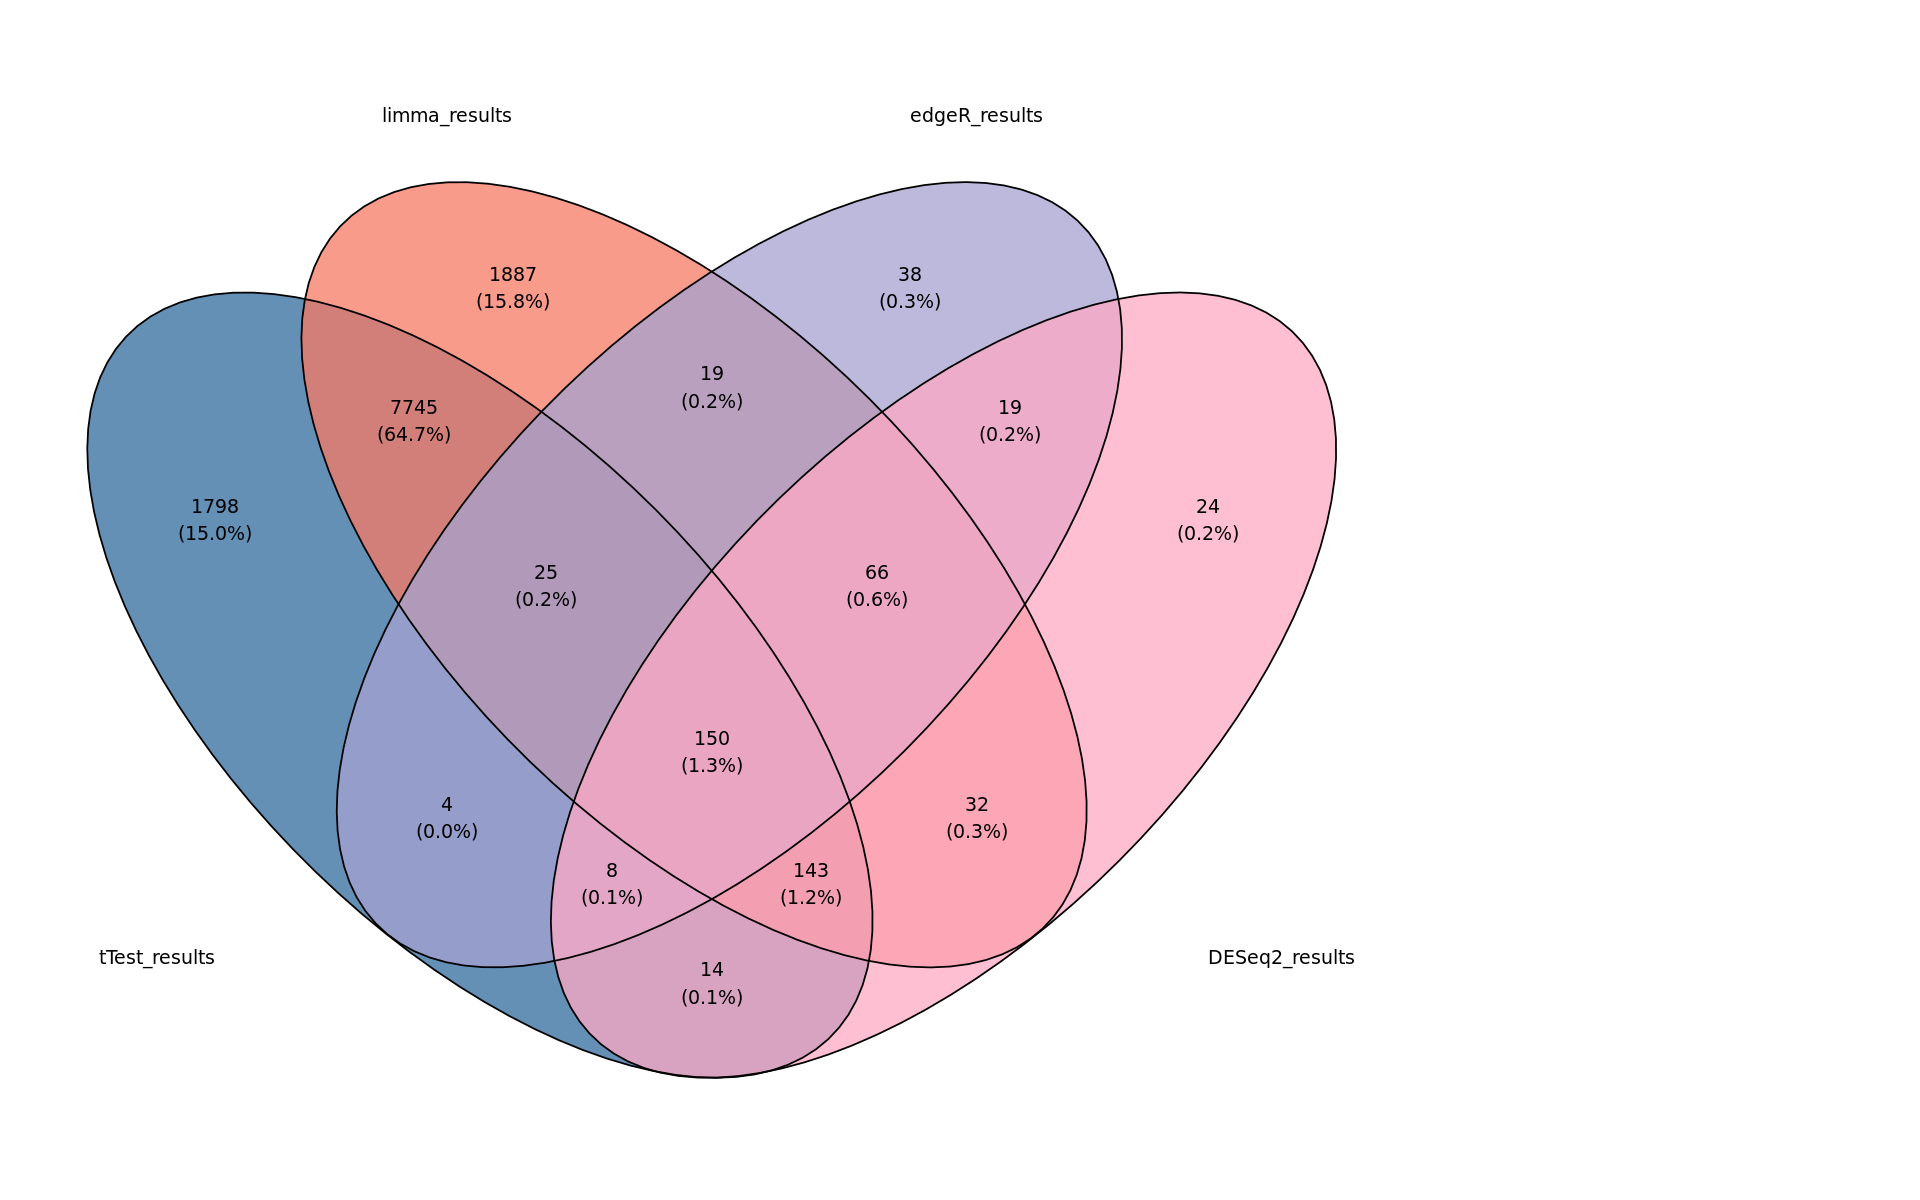

In [49]:
# Adjust size of the plot
options(repr.plot.width = 16, repr.plot.height = 10)
# Create a venn diagram for the results of four different DE analysis methods
plotVenn(aResults = DEResults, pThreshold = 0.05, useFDR = FALSE, stat = "logFC", statThreshold = 0)

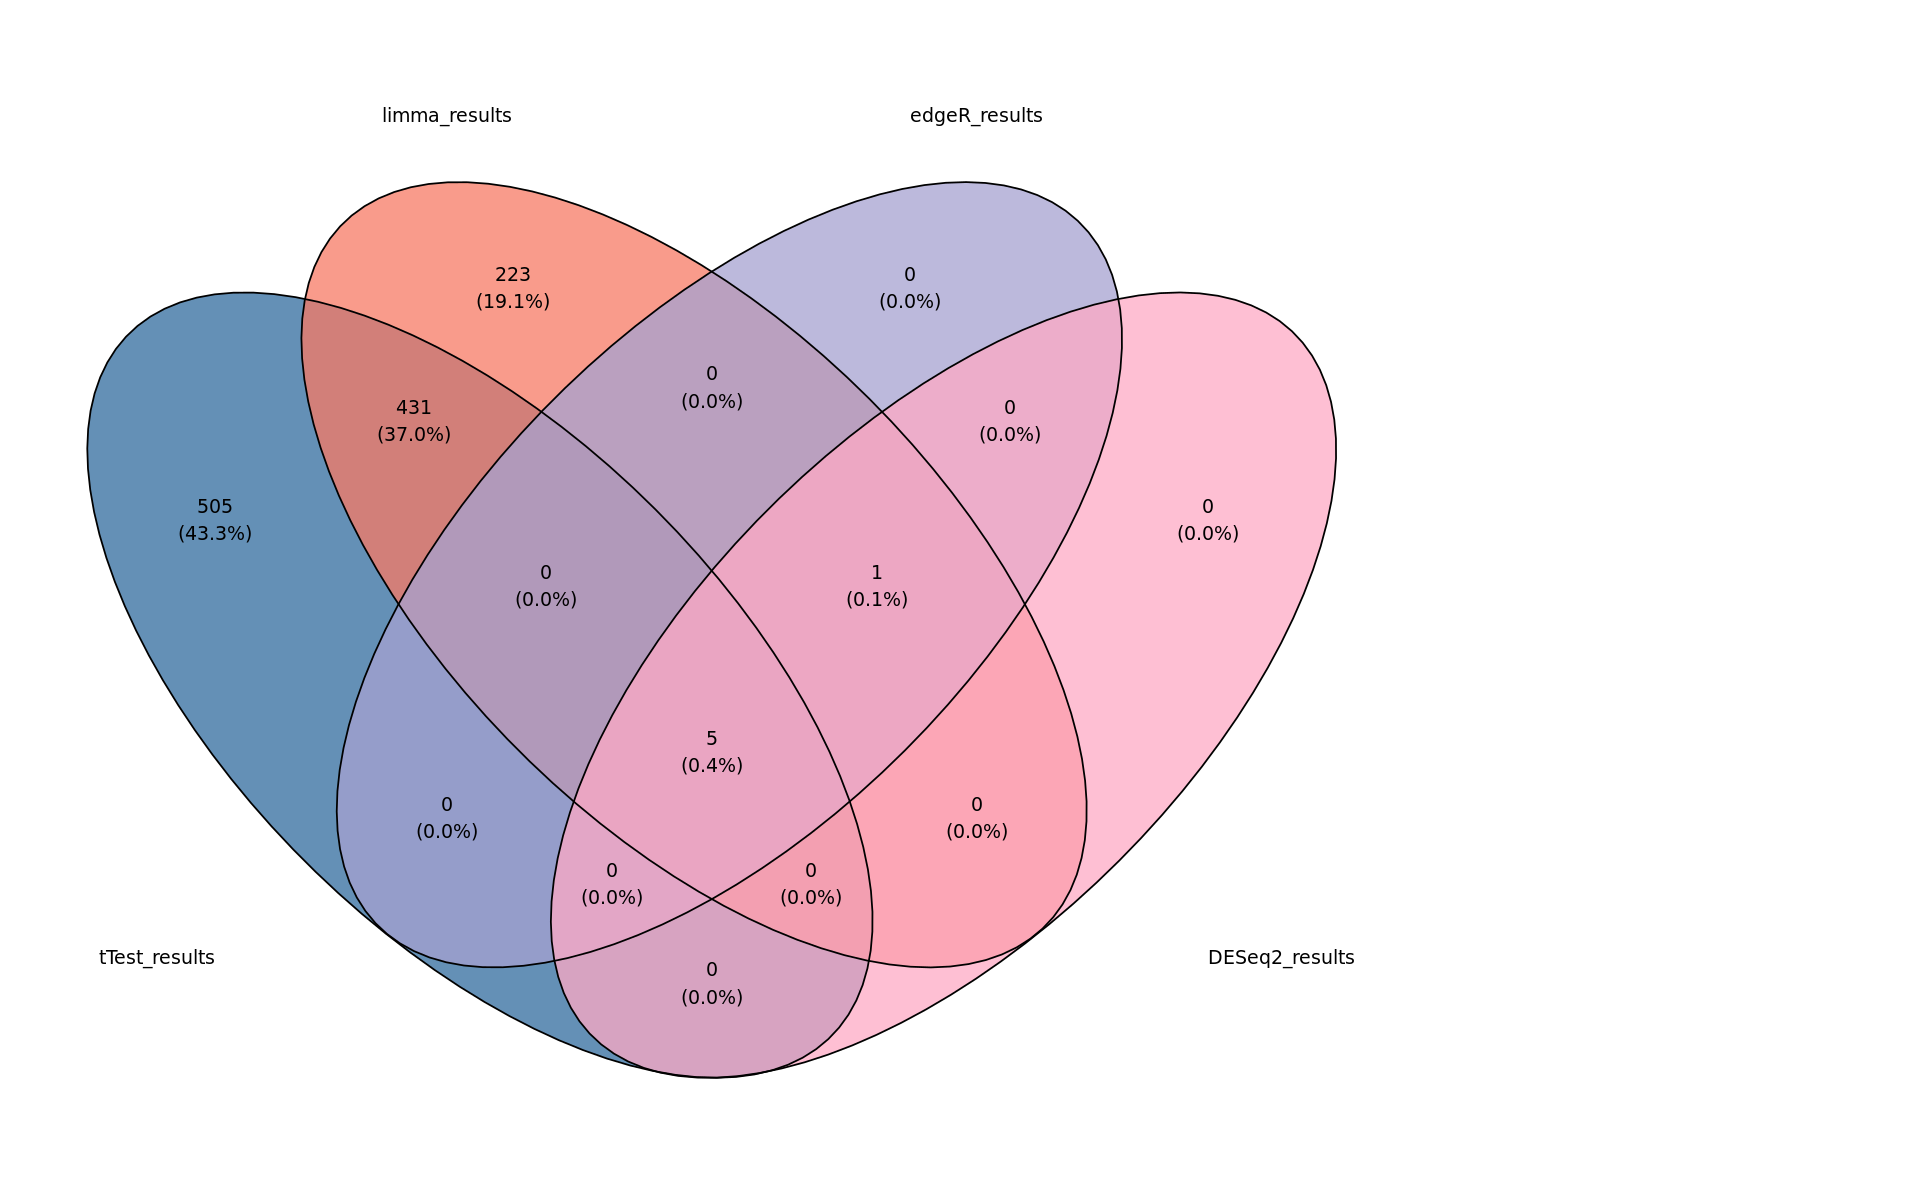

In [50]:
# Adjust size of the plot
options(repr.plot.width = 16, repr.plot.height = 10)
# Create a venn diagram for the results of four different DE analysis methods
plotVenn(aResults = DEResults, pThreshold = 0.05, useFDR = TRUE, stat = "logFC", statThreshold = 0)

In the first Venn diagram, we use the normal p-value for filtering out differentially expressed (DE) genes. The diagram illustrates that 150 genes are common across four distinct analysis methods. The t-Test and limma methods share 7745 common genes.
When using the adjusted p-value (pFDR) as the filtering criterion, there are only five common genes remain in the second diagram. The intersection of t-Test and limma results in this case is reduced to 430 genes.
From these diagrams, we can see the impact of utilizing adjusted p-values on the decision of differentially expressed genes.

For the heatmap plot, we can use the following codes. We will ceate a heat map for 30 genes which belong to the [alzheimer disease pathway](https://www.genome.jp/pathway/hsa05010) in KEGG database. Since KEGG uses SYMBOLSfor gene IDs, we will need to map them to PROBE IDs for plotting in this case. The KEGG database will be thoroughly examined in the upcoming submodule.

Warning message in plotDEGeneHeatmap(DEResults, alzheimer_genes_probeid, useFDR = FALSE, :
“Some input genes are not found in the DE results”


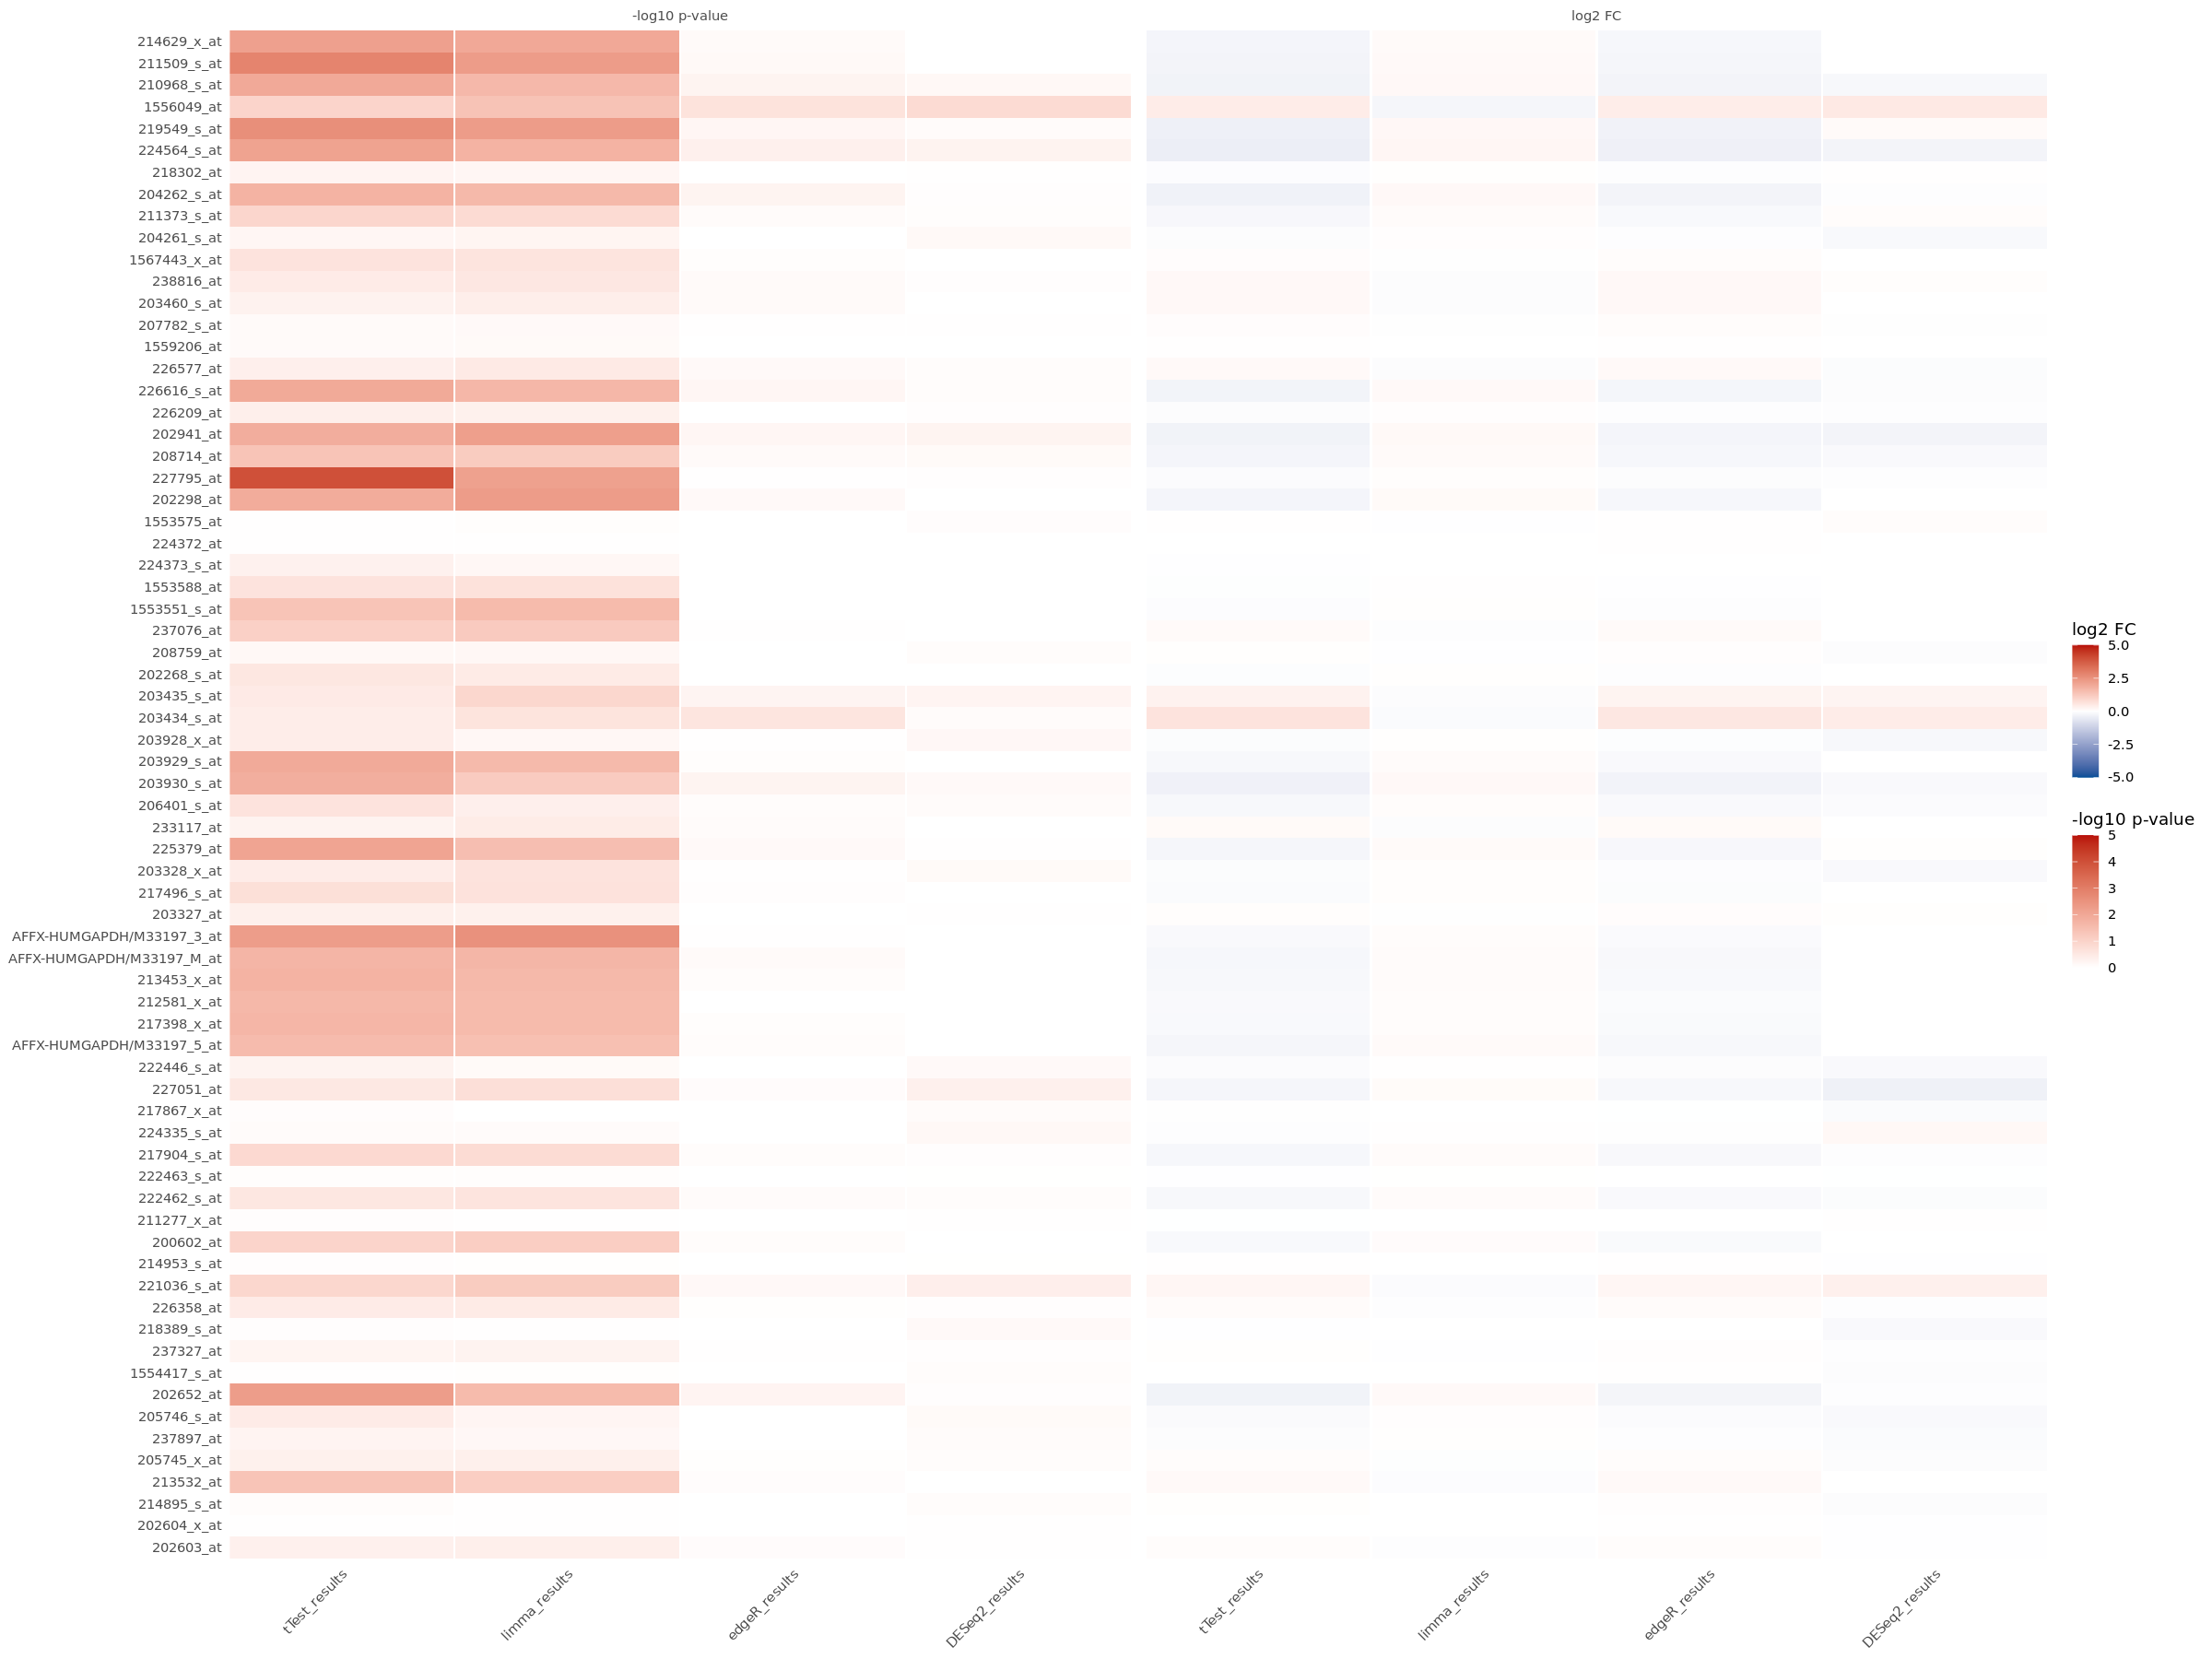

In [51]:
# Create a genes list to plot, it will contains 30 genes of the pathway related to alzheimer disease. 
# Selec genes list for the heat map
alzheimer_genes_symbols <- c("ADAM10","ADAM17","APP",   "NAE1",  "APBB1", "GAPDH", "BACE1", "BACE2",
                             "RTN3",  "RTN4",  "PSENEN","PSEN1", "PSEN2", "NCSTN", "APH1A", "APH1B",
                             "IDE",   "MME",   "MAPT",  "ND1",   "ND2",   "ND3",   "ND4",   "ND4L", 
                             "ND5",   "ND6",   "NDUFV1","NDUFV2","NDUFV3","NDUFA1")
# Map the SYMBOLs to PROBEIDs for plotting
annotLookup <- data$annotLookup
df <- data.frame(SYMBOL = alzheimer_genes_symbols)
data_df = merge(annotLookup, df, by = "SYMBOL")
# Get the genes probeid from the mapped dataframe
alzheimer_genes_probeid <- data_df$`PROBEID`
# Adjust the size of the plot
options(repr.plot.width = 20, repr.plot.height = 15)
# Create a heat map for DE analysis results
plotDEGeneHeatmap(DEResults, alzheimer_genes_probeid, useFDR = FALSE, labels = NULL, logFCLims = c(-5, 5), negLog10pValueLims = c(0, 5))

Warning message in plotDEGeneHeatmap(DEResults, alzheimer_genes_probeid, useFDR = TRUE, :
“Some input genes are not found in the DE results”


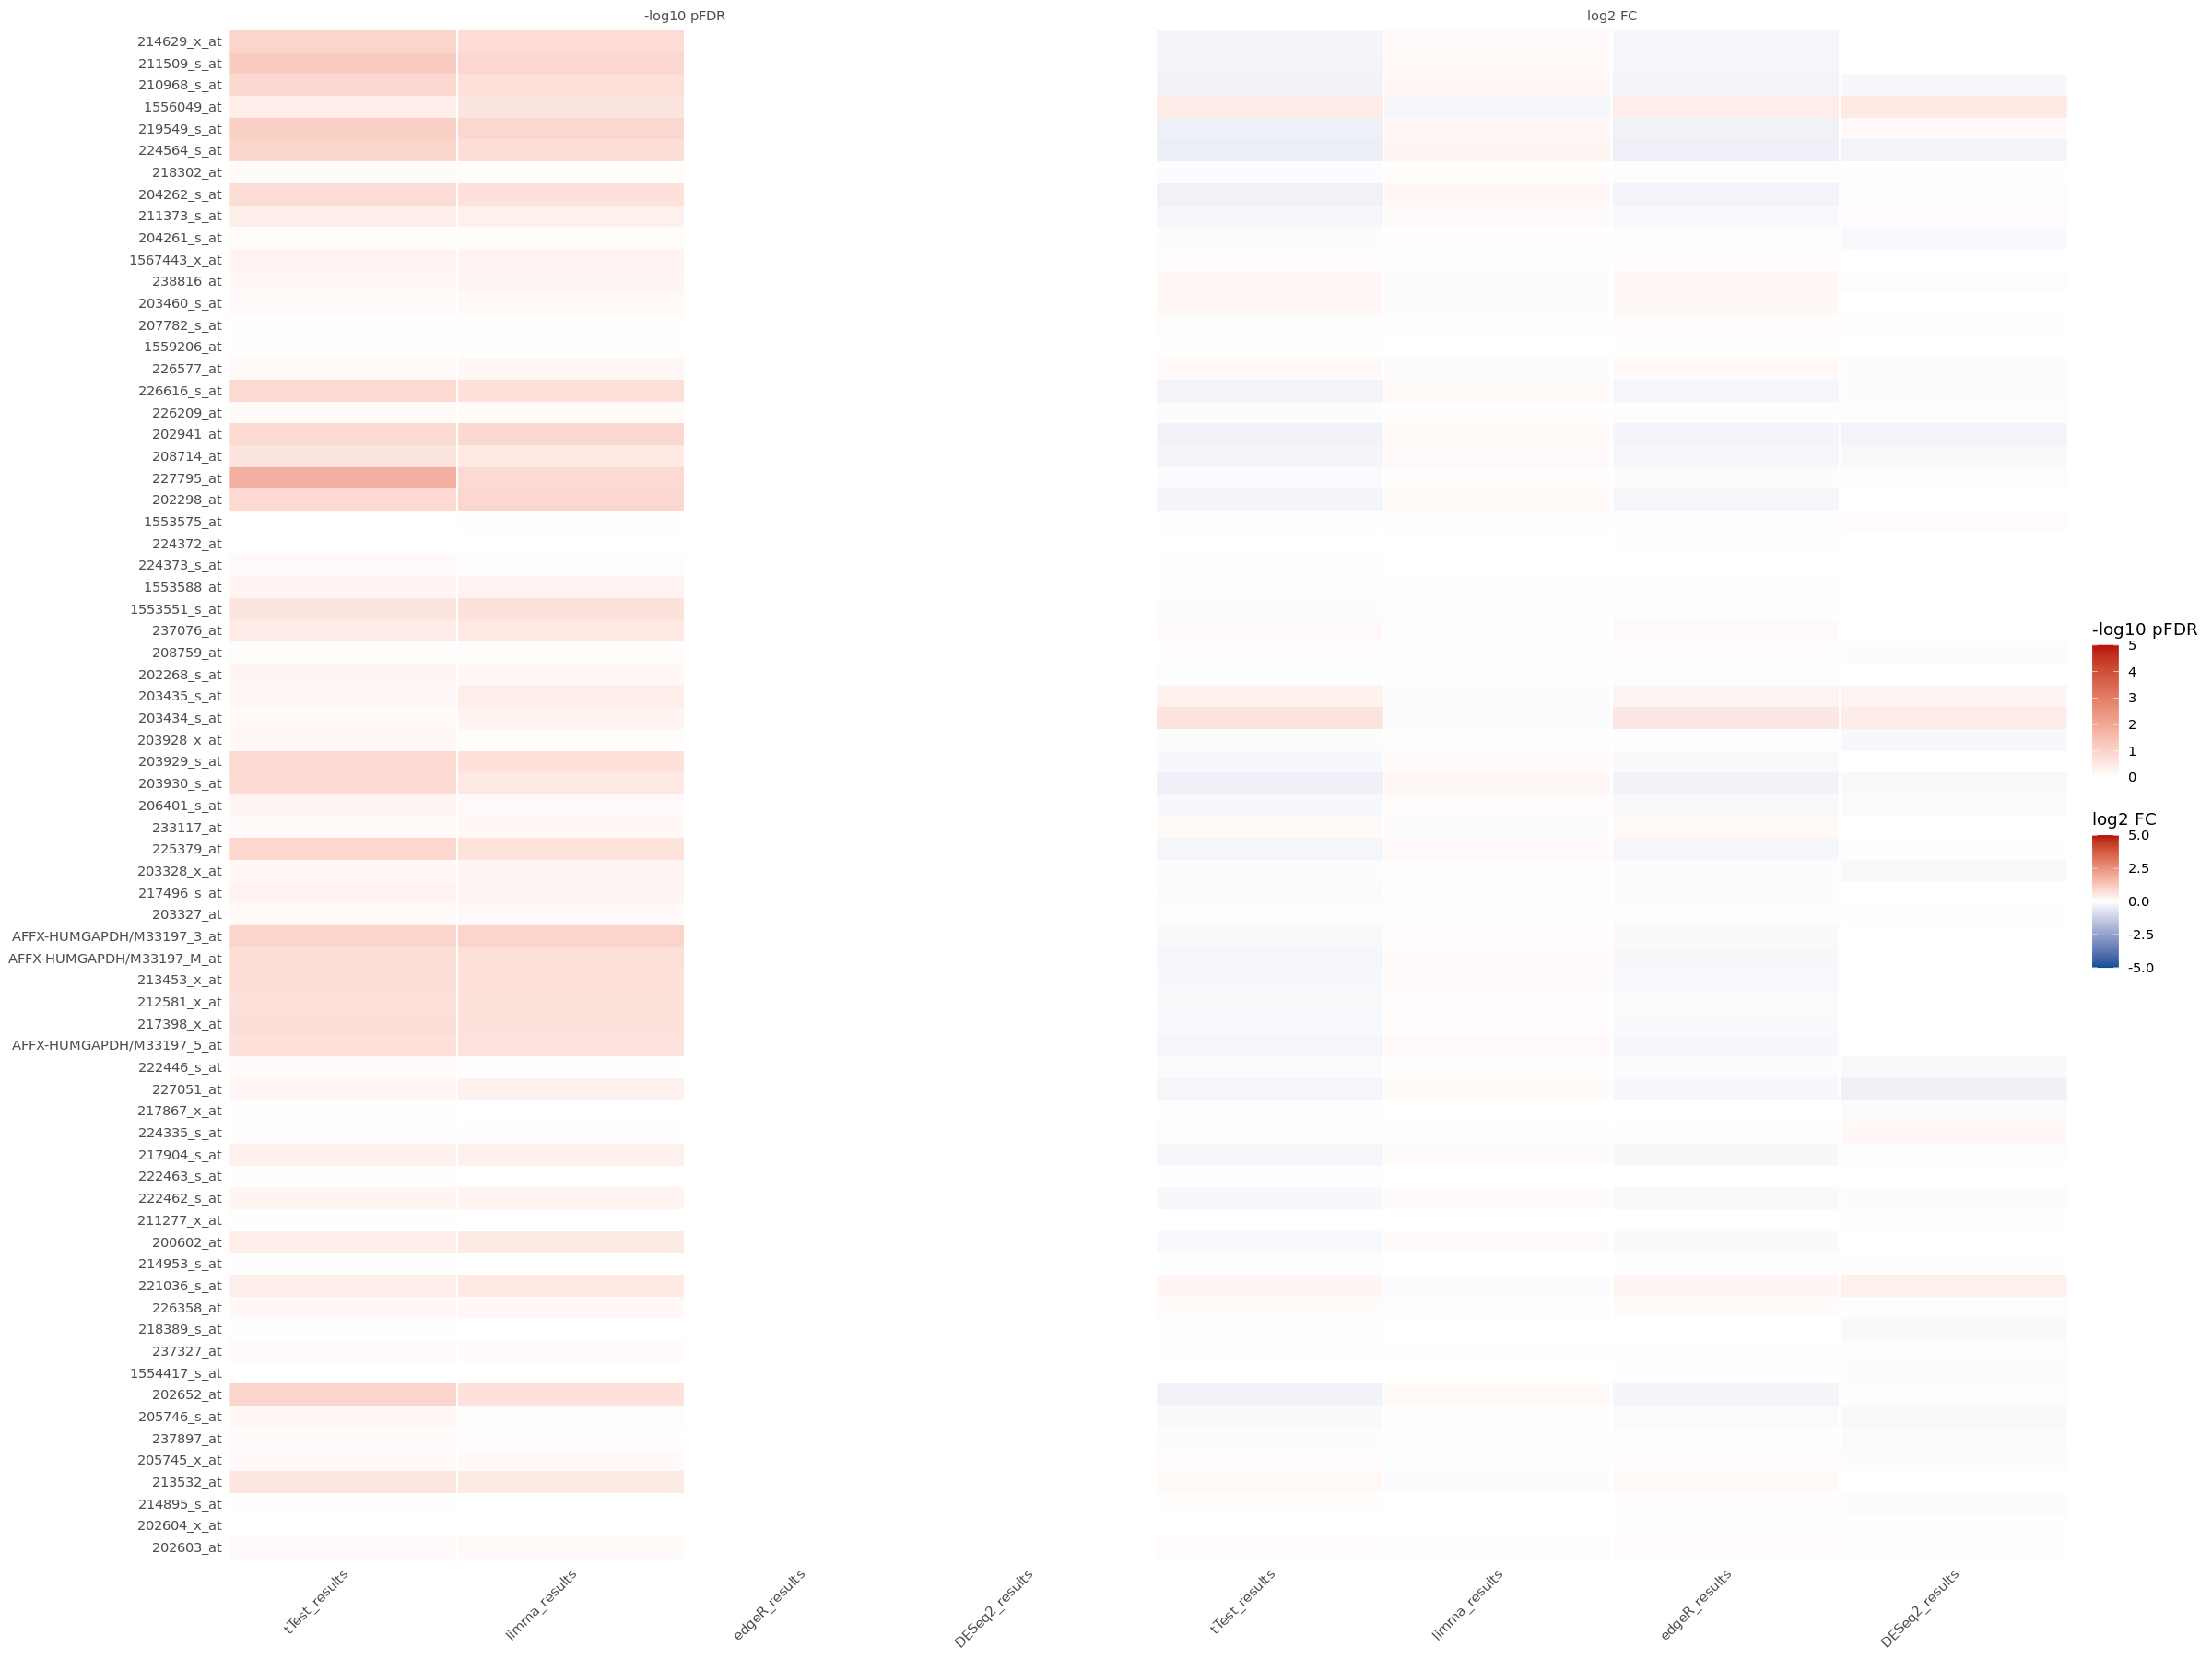

In [52]:
# Adjust the size of the plot
options(repr.plot.width = 20, repr.plot.height = 15)
# Create a heat map for DE analysis results
plotDEGeneHeatmap(DEResults, alzheimer_genes_probeid, useFDR = TRUE, labels = NULL, logFCLims = c(-5, 5), negLog10pValueLims = c(0, 5))

From the above heatmaps, we can see that the analysis results of limma and t-Test on the GEO48350 dataset, which focuses on Human Alzheimer's disease, show multiple genes in common with the genes in the Human Alzheimer pathway of the KEGG database. While edgeR and deseq2 only have some common genes in the first heatmap plot (using normal p-value) and no common gene is presented in the second plot.

In [53]:
# Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule2.html" width=100% height=250></iframe>')

The next submodule will show how to identify the pathways that these genes are involved in. 


In [54]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 11 (bullseye)

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/libopenblasp-r0.3.13.so;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggnewscale_0.4.9            ggvenn_0.1.10              
 [3] dplyr_1.1.4                 tidyr_1.3.0                
 [5] DESeq2_1.42.0               SummarizedExperiment_1.32.0
 [7] Bioba